In [30]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

from time import time 
from six.moves import xrange
from sklearn.manifold import TSNE
from sklearn.mixture import GMM
from sklearn.covariance import graph_lasso

In [2]:
def mean_var_estimate(raw_data):
    """ estimate mean and covariance of raw input data
    
        Args: 
            raw_data: rawdata of size [data_num, data_dim]
        Returns:
            mu: estimated mean
            sigma: estimated variance
    """
    
    mu = np.mean(raw_data, axis=0)
    # calculate mean and covariance matrix of raw data
    data_num = raw_data.shape[0]
    data = raw_data - mu[np.newaxis,:]
    sigma = 1.0/data_num * np.dot(data.T, data)
    
    return mu, sigma

def standard_norm(raw_data, mu, sigma):
    """ Standard normalization to transfer rawdata to zero mean and unit diagonal variance
    
        Args: 
            raw_data: rawdata of size [data_num, data_dim]
            mu: estimated mean from training data 
            sigma: estimated variance from training data
        Returns:
            data: data after transformation
    """
    data = raw_data - mu[np.newaxis,:] 
    sigma_diag = np.diag(1.0 / np.sqrt(np.diag(sigma)))
    data = np.dot(data, sigma_diag)
    
    return data 

def block_decomp_matrix(data, i):
    """ Decompose current data into submatrix blocks with the delimiter of i-th row and i-th column
        Args:
            data: data to process with size of [data_num, data_dim]
            i: the i-th row and column as delimiter
        Returns:
            W: block submatrix after deleting i-th row and i-th column from data
            w: the i-th column of data without the (i,i)-th element
            sigma: the (i,i)-th element
    """
    
    data_dim = data.shape[1]
    tmp = data[i,:][np.arange(data_dim) != i]
    w = tmp[:, np.newaxis]
    tmp = data[np.arange(data_dim) != i,:]
    W = tmp[:, np.arange(data_dim) != i]
    sigma = data[i,i]
    
    return W, w, sigma

In [3]:
def graphic_lasso(data, rho, thres_Lamb=1.0e-3, thres_beta= 1.0e-6):
    """ use block coordinate desecent algorithm to calcualte the optimal covariance matrix sigma 
        and use the obtained sigma to calculate anomaly score
        
        Args:
            data: raw training data of size [data_num, data_dim]
            rho: regularization factor/parameter 
            thres_beta: threshold of beta to judge whether the algorithm converges or not
            thres_Lamb: norm threshold of estimated covariance matrix 
        Returns:
            Lamb: optimized precision matrix 
            Lamb_inv: optimized inverse precision matrix
    """
    # initialization 
    data_num = data.shape[0] 
    data_dim = data.shape[1]
    # s is fixed, the target is to optimize Lamb and Lamb_inv
    S = 1.0/data_num * np.dot(data.T, data)
    Lamb = np.linalg.pinv(S)
    Lamb_prev = np.zeros((data_dim, data_dim), dtype= float)
    Lamb_inv = np.copy(S) 
    
    cnt = 0 
    while np.linalg.norm(Lamb - Lamb_prev) >= thres_Lamb:
        Lamb_prev = np.copy(Lamb)
        # main loop
        for i in xrange(data_dim):
            W, w, sigma = block_decomp_matrix(Lamb_inv, i)
            _, s, s_ii = block_decomp_matrix(S, i)
            _, l, lamb = block_decomp_matrix(Lamb, i)

            # initial beta
            beta = np.dot(np.linalg.pinv(W), w)
            beta_prev = np.zeros((data_dim-1, 1), dtype=float) 
            while np.linalg.norm(beta - beta_prev) >= thres_beta:
                beta_prev = np.copy(beta)

                for j in xrange(data_dim -1):
                    beta_k = beta[np.arange(data_dim -1) != j]
                    W_jk = W[j, np.arange(data_dim -1) != j][:,np.newaxis]
                    A_j = float(s[j, 0] - np.dot(W_jk.T, beta_k))

                    if A_j > rho:
                        beta[j,0] = (A_j - rho) / W[j, j] 
                    elif A_j >= -1.0*rho:
                        beta[j,0] = 0.0
                    elif A_j < -1.0 * rho:
                        beta[j,0] = (A_j + rho) / W[j, j] 
                    else:
                        print "illegal input of Aj"                 
                        
            # update w, sigma and Lamb_inv     
            w = np.dot(W, beta)
            sigma = s_ii + rho
            Lamb_inv[i, np.arange(data_dim) != i] = w.T
            Lamb_inv[np.arange(data_dim) != i, i] = w.T  
            Lamb_inv[i,i] = sigma 

            # update l and lamb
            lamb = 1.0 / (sigma - np.dot(np.dot(beta.T, W), beta))
            l = -1.0 / (sigma - np.dot(np.dot(beta.T, W), beta)) * beta 
            Lamb[i, np.arange(data_dim) != i] = l.T
            Lamb[np.arange(data_dim) != i, i] = l.T  
            Lamb[i,i] = lamb
        cnt = cnt + 1 
        if cnt >= 1000:
            print "beyond the maximum loop number"
            break
        diff = np.linalg.norm(Lamb - Lamb_prev)
        if np.mod(cnt, 50) == 0:
            print "loop {} : variance diff - {}".format(cnt, diff)
    return Lamb, Lamb_inv
    

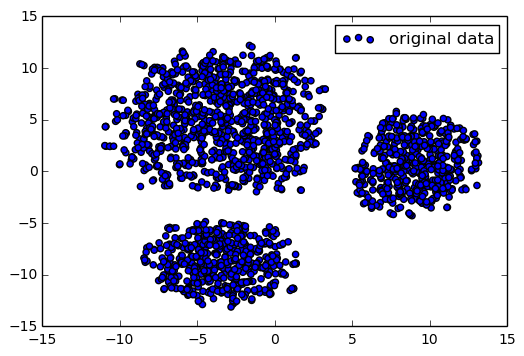

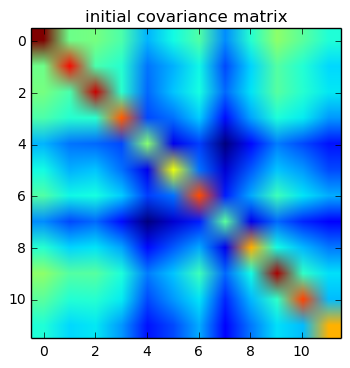

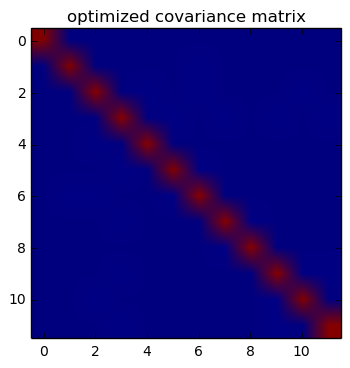

In [41]:
## easy demo 
if __name__== "__main__":
    # generate random data for covariance estimation 
    obs = (np.concatenate((np.random.randn(500, 12), 
                      10 + np.random.randn(500, 12), 
                      20 + np.random.randn(1000, 12))))

    # visualize generated data using TSNE
    model = TSNE(n_components=2, random_state= 0)
    x_embed = model.fit_transform(obs)
    plt.figure()
    plt.scatter(x_embed[:,0], x_embed[:,1]) 
    plt.legend(["original data"])
    
    rho = 0.1
    emp_cov = np.cov(obs.T)
    plt.figure()
    plt.imshow(emp_cov) 
    plt.title("initial covariance matrix")
    
    # use graphic_lasso to estimate coordinate variance matrix 
    mu, var = mean_var_estimate(obs)
    obs = standard_norm(obs, mu, var)
    Lamb, Lamb_inv = graphic_lasso(obs, rho) 
    plt.figure()
    plt.imshow(Lamb)
    plt.title("optimized covariance matrix")